<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [45]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [47]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [49]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [50]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


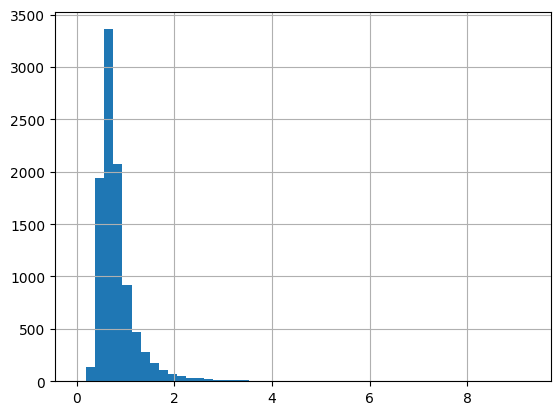

In [51]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

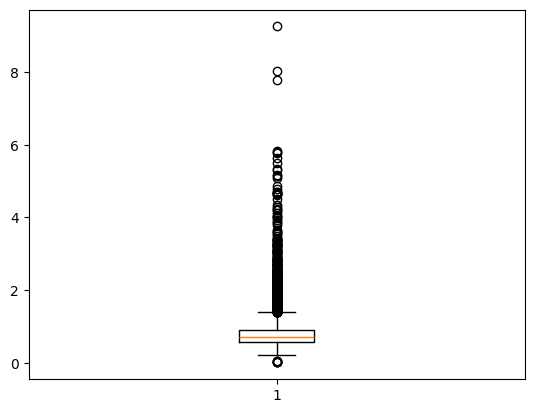

In [52]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [53]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


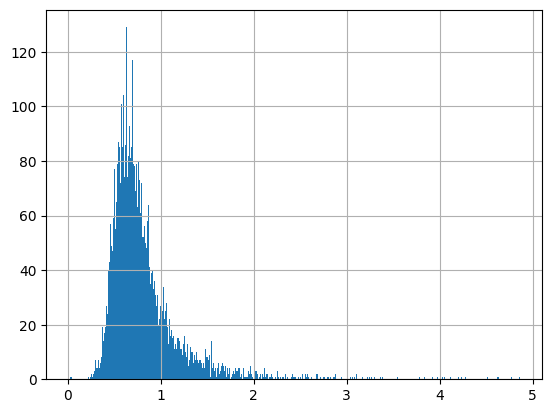

In [54]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

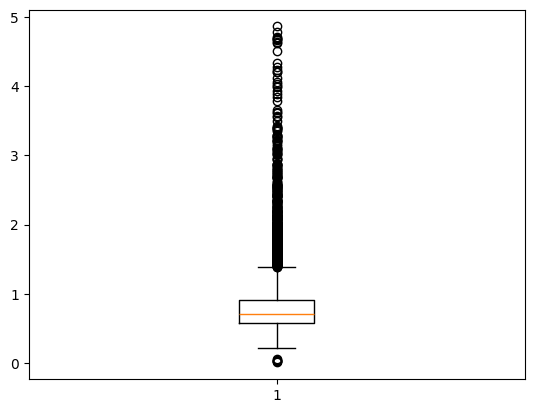

In [55]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [57]:
# Define drift function for Model 2, dependent on task and HSF_emo conditions
def drift_function(task_1, task_2, task_3, HSF_emo_1, HSF_emo_2, 
                  drift_task1, drift_task2, drift_task3, drift_emo1, drift_emo2, 
                  leak, t, x):
    base_drift = (drift_task1 * task_1 + drift_task2 * task_2 + drift_task3 * task_3 +
                  drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2)  # Compute base drift as a linear combination of conditions
    drift = base_drift - leak * x  # Apply leaky integrator to adjust drift based on accumulated evidence
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):  # Check for numerical errors (NaN or infinite values)
        print(f"Drift function error: {drift}")
    return drift * np.ones_like(x)  # Ensure output shape matches input x for compatibility with pyDDM

In [58]:
# Define bound function with exponential decay
def bound_function(threshold, invtau, t):
    bound = threshold * np.exp(-t * invtau)  # Calculate exponentially decaying boundary
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):  # Check for numerical errors (NaN or infinite values)
        print(f"Bound function error: {bound}")
    return bound

<a id="section5"></a>
# 5. Build and Configure Model

In [60]:
# Build and configure Model 2 with drift dependent on task and HSF_emo conditions
model_2 = pyddm.gddm(
    drift=drift_function,  # Use the custom task- and HSF_emo-dependent drift function
    noise=1.0,             # Fixed noise level for the diffusion process
    bound=bound_function,  # Use the custom exponential decay bound function
    nondecision="nt",      # Non-decision time parameter
    starting_position="x0",# Starting position parameter for evidence accumulation
    parameters={
        "drift_task1": (-1, 1), "drift_task2": (-1, 1), "drift_task3": (-1, 1),  # Ranges for task drift parameters
        "drift_emo1": (0, 2), "drift_emo2": (-1, 1),                             # Ranges for HSF_emo drift parameters
        "threshold": (0.5, 2),         # Range for initial decision threshold
        "x0": (-0.3, 0.3),           # Range for starting position of evidence
        "nt": (0.1, 1),              # Range for non-decision time
        "leak": (0, 0.03),       # Range for leak parameter in the integrator
        "invtau": (0.1, 2)           # Range for decay rate in the bound function
    },
    conditions=["task_1", "task_2", "task_3", "HSF_emo_1", "HSF_emo_2"],  # Specify task and HSF_emo dummy variables as conditions
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [62]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [64]:
# Attempt to fit Model 2 to the filtered data sample using BIC loss
try:
    model_2.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Error during Model 2 fitting: {e}")  # Report any fitting errors for debugging
    print(f"Current Model 2 parameters: {model_2.parameters}")  # Display parameters if fitting fails
model_2.show()  # Display the fitted model details

Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.022248670867753173, minval=-1, maxval=1), drift_task2=Fitted(0.22269665979631625, minval=-1, maxval=1), drift_task3=Fitted(0.5666232901942241, minval=-1, maxval=1), drift_emo1=Fitted(1.860389614231864, minval=0, maxval=2), drift_emo2=Fitted(-0.03970903366478529, minval=-1, maxval=1), leak=Fitted(0.005451820531973116, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8337584289334324, minval=0.5, maxval=2), invtau=Fitted(1.1182659979125797, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.015566486213970408, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.15154543766295564, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=35569.73069456052
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.017383565684087943, minval=-1, maxval=1), drift_task2=Fitted(-0.42446342321904973, min

differential_evolution step 1: f(x)= 16312.571385680842


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.395327596477137, minval=-1, maxval=1), drift_task2=Fitted(-0.20789122509500335, minval=-1, maxval=1), drift_task3=Fitted(-0.31690376677642773, minval=-1, maxval=1), drift_emo1=Fitted(1.501366734986524, minval=0, maxval=2), drift_emo2=Fitted(-0.12630858977643222, minval=-1, maxval=1), leak=Fitted(0.008587556100050391, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.1986443718485362, minval=0.5, maxval=2), invtau=Fitted(0.23649230758158335, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.060566519981849476, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1997461518234679, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18902.911840297034
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.29922186156999575, minval=-1, maxval=1), drift_task2=Fitted(-0.10492231795532958, minva

differential_evolution step 2: f(x)= 15507.084493953107


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.017383565684087943, minval=-1, maxval=1), drift_task2=Fitted(-0.42446342321904973, minval=-1, maxval=1), drift_task3=Fitted(-0.5623787365601738, minval=-1, maxval=1), drift_emo1=Fitted(1.2828817791396308, minval=0, maxval=2), drift_emo2=Fitted(-0.287735284346204, minval=-1, maxval=1), leak=Fitted(0.016320328238046366, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.6100172896024134, minval=0.5, maxval=2), invtau=Fitted(0.6020010781830709, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.23774265558896296, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.27055933709304175, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=31323.45683638144
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.9078062824487634, minval=-1, maxval=1), drift_task2=Fitted(-0.09795713175677156, minval

differential_evolution step 3: f(x)= 15507.084493953107


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.16596973859614605, minval=-1, maxval=1), drift_task2=Fitted(-0.03164297437009611, minval=-1, maxval=1), drift_task3=Fitted(-0.05680233120351719, minval=-1, maxval=1), drift_emo1=Fitted(1.2828817791396308, minval=0, maxval=2), drift_emo2=Fitted(-0.13741422923366065, minval=-1, maxval=1), leak=Fitted(0.016320328238046366, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.6100172896024134, minval=0.5, maxval=2), invtau=Fitted(1.2890153343451787, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.05205895865066017, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1711154233143075, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15448.392294466477
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.43458588496198725, minval=-1, maxval=1), drift_task2=Fitted(0.24289773622740451, minv

differential_evolution step 4: f(x)= 15448.392294466477


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.7390578710772542, minval=-1, maxval=1), drift_task2=Fitted(-0.4054087279636912, minval=-1, maxval=1), drift_task3=Fitted(-0.4816535188205908, minval=-1, maxval=1), drift_emo1=Fitted(0.5651701929287057, minval=0, maxval=2), drift_emo2=Fitted(-0.43601965822762256, minval=-1, maxval=1), leak=Fitted(0.018937864344679232, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8988373101045788, minval=0.5, maxval=2), invtau=Fitted(0.6166537385617352, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.013411097971350228, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3117794046815663, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16570.20684950101
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.9050711683281882, minval=-1, maxval=1), drift_task2=Fitted(0.7333943763013924, minval=-1

differential_evolution step 5: f(x)= 15448.392294466477


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.9615753073905426, minval=-1, maxval=1), drift_task2=Fitted(-0.59233667326611, minval=-1, maxval=1), drift_task3=Fitted(0.12883217686791593, minval=-1, maxval=1), drift_emo1=Fitted(1.0915071757753896, minval=0, maxval=2), drift_emo2=Fitted(-0.333021323128476, minval=-1, maxval=1), leak=Fitted(0.0025878730983125917, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6201375136912675, minval=0.5, maxval=2), invtau=Fitted(1.6339856442712826, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.013411097971350228, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1974346572852349, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=56086.528750754915
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.9050711683281882, minval=-1, maxval=1), drift_task2=Fitted(-0.5152960354965248, minval=-1,

differential_evolution step 6: f(x)= 15448.392294466477


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.07250888128935795, minval=-1, maxval=1), drift_task2=Fitted(-0.4054087279636912, minval=-1, maxval=1), drift_task3=Fitted(-0.18329789213434577, minval=-1, maxval=1), drift_emo1=Fitted(1.0558718609383575, minval=0, maxval=2), drift_emo2=Fitted(0.5810457340138906, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.5210614017425463, minval=0.5, maxval=2), invtau=Fitted(1.4557353838084366, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.013411097971350228, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2623988341544395, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18061.98716049835
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.1612456734825487, minval=-1, maxval=1), drift_task2=Fitted(-0.3774966970585769, minval=-

differential_evolution step 7: f(x)= 15375.7019822155


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.09047881930381552, minval=-1, maxval=1), drift_task2=Fitted(0.08686633549902956, minval=-1, maxval=1), drift_task3=Fitted(-0.3843398792893675, minval=-1, maxval=1), drift_emo1=Fitted(1.6110242747221575, minval=0, maxval=2), drift_emo2=Fitted(0.5624496991045511, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0594623447782048, minval=0.5, maxval=2), invtau=Fitted(0.35165464347584807, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.013411097971350228, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.323975459064389, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18773.196217959998
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.2327929119276999, minval=-1, maxval=1), drift_task2=Fitted(0.4828860161289039, minval=-

differential_evolution step 8: f(x)= 15029.974410850975


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.27262058904227937, minval=-1, maxval=1), drift_task2=Fitted(-0.4054087279636912, minval=-1, maxval=1), drift_task3=Fitted(-0.1052944997724139, minval=-1, maxval=1), drift_emo1=Fitted(1.417088687474908, minval=0, maxval=2), drift_emo2=Fitted(-0.43601965822762256, minval=-1, maxval=1), leak=Fitted(0.018667568234954753, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8481107352271366, minval=0.5, maxval=2), invtau=Fitted(1.1492701258456541, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.24211713134213064, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1974346572852349, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=28115.56468574294
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.2327929119276999, minval=-1, maxval=1), drift_task2=Fitted(0.4828860161289039, minval=-

differential_evolution step 9: f(x)= 14836.497442131726


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(-0.3520506072716263, minval=-1, maxval=1), drift_task3=Fitted(-0.2943932499924662, minval=-1, maxval=1), drift_emo1=Fitted(1.0558718609383575, minval=0, maxval=2), drift_emo2=Fitted(-0.43601965822762256, minval=-1, maxval=1), leak=Fitted(0.022234926929113406, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8178752724224623, minval=0.5, maxval=2), invtau=Fitted(0.18811482206180474, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.17218863271533064, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2583201352016924, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17256.64581269892
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.37563604884976276, minval=-1, maxval=1), drift_task2=Fitted(0.4828860161289039, minva

differential_evolution step 10: f(x)= 14693.498463769542


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.3842793555472013, minval=-1, maxval=1), drift_task2=Fitted(-0.4054087279636912, minval=-1, maxval=1), drift_task3=Fitted(-0.22054658206559974, minval=-1, maxval=1), drift_emo1=Fitted(0.3153635100056793, minval=0, maxval=2), drift_emo2=Fitted(-0.43601965822762256, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7249176684094472, minval=0.5, maxval=2), invtau=Fitted(0.5783008635528367, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.1882378887372546, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33328291901809687, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17709.62461395945
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.6480663200341837, minval=-1, maxval=1), drift_task2=Fitted(-0.45943991767300907, minval

differential_evolution step 11: f(x)= 14693.498463769542


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(0.3254503168628138, minval=-1, maxval=1), drift_task3=Fitted(0.014216578488535081, minval=-1, maxval=1), drift_emo1=Fitted(0.8577434947285657, minval=0, maxval=2), drift_emo2=Fitted(0.3228794554709209, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.322740018148451, minval=0.5, maxval=2), invtau=Fitted(1.1492701258456541, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.07567755805466611, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.21916002521621064, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16153.403969413415
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.2327929119276999, minval=-1, maxval=1), drift_task2=Fitted(0.4828860161289039, minval=-

differential_evolution step 12: f(x)= 14693.498463769542


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.689666685523465, minval=-1, maxval=1), drift_task2=Fitted(-0.24393691336133294, minval=-1, maxval=1), drift_task3=Fitted(-0.5201103799366218, minval=-1, maxval=1), drift_emo1=Fitted(0.9214141615596627, minval=0, maxval=2), drift_emo2=Fitted(0.19736860425767655, minval=-1, maxval=1), leak=Fitted(0.01668413850451224, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7191484378555563, minval=0.5, maxval=2), invtau=Fitted(0.18687661495832952, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.013411097971350228, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.355586664481813, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15515.221211327342
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.2327929119276999, minval=-1, maxval=1), drift_task2=Fitted(0.4828860161289039, minval=-1

differential_evolution step 13: f(x)= 14645.430580986302


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.5462073449797167, minval=-1, maxval=1), drift_task2=Fitted(-0.5901570766814179, minval=-1, maxval=1), drift_task3=Fitted(-0.8935282374159319, minval=-1, maxval=1), drift_emo1=Fitted(1.6498621733135588, minval=0, maxval=2), drift_emo2=Fitted(0.022543310775278158, minval=-1, maxval=1), leak=Fitted(0.017952353752035723, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8108426749915781, minval=0.5, maxval=2), invtau=Fitted(0.4036887047401263, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.06102965980094268, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26202089549108787, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16080.118053359633
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(0.2928359457796732, minval

differential_evolution step 14: f(x)= 14645.430580986302


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7366133959647229, minval=-1, maxval=1), drift_task2=Fitted(0.16810710853259603, minval=-1, maxval=1), drift_task3=Fitted(-0.5287222125498106, minval=-1, maxval=1), drift_emo1=Fitted(1.2905590571691594, minval=0, maxval=2), drift_emo2=Fitted(-0.12454040326079929, minval=-1, maxval=1), leak=Fitted(0.013585063588051517, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8915717350743451, minval=0.5, maxval=2), invtau=Fitted(1.1492701258456541, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.013411097971350228, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1974346572852349, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=24432.996718673257
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.15723998795837568, minval=-1, maxval=1), drift_task2=Fitted(-0.4529955902781374, minval

differential_evolution step 15: f(x)= 14645.430580986302


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7081828829462011, minval=-1, maxval=1), drift_task2=Fitted(-0.5407532794470253, minval=-1, maxval=1), drift_task3=Fitted(-0.2801444669317599, minval=-1, maxval=1), drift_emo1=Fitted(1.6759121027545403, minval=0, maxval=2), drift_emo2=Fitted(-0.10270341884698986, minval=-1, maxval=1), leak=Fitted(0.018178446345138086, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8872163933598185, minval=0.5, maxval=2), invtau=Fitted(0.23149920574687166, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.09259777983579338, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3102567645890738, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14995.394399781453
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(-0.5069948445496049, minva

differential_evolution step 16: f(x)= 14484.137804979378


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.710077594466014, minval=-1, maxval=1), drift_task2=Fitted(-0.7927413933630016, minval=-1, maxval=1), drift_task3=Fitted(-0.5738918942865239, minval=-1, maxval=1), drift_emo1=Fitted(1.3630887494528667, minval=0, maxval=2), drift_emo2=Fitted(0.23278988107755683, minval=-1, maxval=1), leak=Fitted(0.027294324726366913, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8727987173597953, minval=0.5, maxval=2), invtau=Fitted(0.2480661849505601, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.03112811989724109, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2889803581553858, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14908.340035041985
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7172490688432536, minval=-1, maxval=1), drift_task2=Fitted(-0.5069948445496049, minval=-1

differential_evolution step 17: f(x)= 14484.137804979378


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.668207543023286, minval=-1, maxval=1), drift_task2=Fitted(-0.2749771276062314, minval=-1, maxval=1), drift_task3=Fitted(-0.5738918942865239, minval=-1, maxval=1), drift_emo1=Fitted(1.096554142960077, minval=0, maxval=2), drift_emo2=Fitted(0.17523010528837224, minval=-1, maxval=1), leak=Fitted(0.024280947124055978, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8727987173597953, minval=0.5, maxval=2), invtau=Fitted(0.29438415486405545, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.03112811989724109, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.18240644919577748, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17358.208771304206
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7901756502711075, minval=-1, maxval=1), drift_task2=Fitted(-0.6985841392313663, minval=-

differential_evolution step 18: f(x)= 14484.137804979378


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.737417203898755, minval=-1, maxval=1), drift_task2=Fitted(-0.5559970303840593, minval=-1, maxval=1), drift_task3=Fitted(-0.5738918942865239, minval=-1, maxval=1), drift_emo1=Fitted(1.3715095097676802, minval=0, maxval=2), drift_emo2=Fitted(0.1842891784017915, minval=-1, maxval=1), leak=Fitted(0.024280947124055978, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9671971508173702, minval=0.5, maxval=2), invtau=Fitted(0.31467533261472125, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01267248402540414, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30604745537573663, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15648.231986588677
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.9115698831693471, minval=-1, maxval=1), drift_task2=Fitted(-0.39455240073228737, minval

differential_evolution step 19: f(x)= 14470.252650976483


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.007328190105241994, minval=-1, maxval=1), drift_task2=Fitted(-0.756151160702608, minval=-1, maxval=1), drift_task3=Fitted(0.5702591715658136, minval=-1, maxval=1), drift_emo1=Fitted(1.8863594641462784, minval=0, maxval=2), drift_emo2=Fitted(0.45473065818961866, minval=-1, maxval=1), leak=Fitted(0.01964807288117277, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8259964980972512, minval=0.5, maxval=2), invtau=Fitted(0.31368016624660544, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.19849650581291178, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32277212795603766, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21077.15304360956
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(-0.9103502113785712, minval=

differential_evolution step 20: f(x)= 14470.252650976483


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.640636137040772, minval=-1, maxval=1), drift_task2=Fitted(-0.756151160702608, minval=-1, maxval=1), drift_task3=Fitted(0.5284668938599508, minval=-1, maxval=1), drift_emo1=Fitted(1.8821078174469361, minval=0, maxval=2), drift_emo2=Fitted(0.31898722130720536, minval=-1, maxval=1), leak=Fitted(0.020013421532413422, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9785619664423942, minval=0.5, maxval=2), invtau=Fitted(0.3581276018250621, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.05397899014135534, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30042643209954617, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17622.194820276494
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(-0.8725473816310296, minval=-1

differential_evolution step 21: f(x)= 14470.252650976483


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08013023190832858, minval=-1, maxval=1), drift_task2=Fitted(0.2863349288173924, minval=-1, maxval=1), drift_task3=Fitted(-0.7505541811384215, minval=-1, maxval=1), drift_emo1=Fitted(1.7100132061799864, minval=0, maxval=2), drift_emo2=Fitted(0.7286313683619972, minval=-1, maxval=1), leak=Fitted(0.014062598643547046, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.522249907036, minval=0.5, maxval=2), invtau=Fitted(0.1846582095401751, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.04521836499162785, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.397106931123001, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21588.567763694
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.8835970355135048, minval=-1, maxval=1), drift_task2=Fitted(0.5347655604339943, minval=-1, maxval=

differential_evolution step 22: f(x)= 14470.252650976483


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8336378504910691, minval=-1, maxval=1), drift_task2=Fitted(-0.6324093873991079, minval=-1, maxval=1), drift_task3=Fitted(-0.7326400489576462, minval=-1, maxval=1), drift_emo1=Fitted(1.6967503278048794, minval=0, maxval=2), drift_emo2=Fitted(0.05657408275765752, minval=-1, maxval=1), leak=Fitted(0.007336007082891186, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9186894574785668, minval=0.5, maxval=2), invtau=Fitted(0.1846582095401751, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.057167507311648935, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3225346476232498, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16185.869929894403
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.6421542379322248, minval=-1, maxval=1), drift_task2=Fitted(-0.4579393678820176, minval

differential_evolution step 23: f(x)= 14470.252650976483


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4651476367699954, minval=-1, maxval=1), drift_task2=Fitted(-0.3900867079112743, minval=-1, maxval=1), drift_task3=Fitted(-0.42067646802550107, minval=-1, maxval=1), drift_emo1=Fitted(1.43549460958708, minval=0, maxval=2), drift_emo2=Fitted(0.11981882523510379, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0679511164000268, minval=0.5, maxval=2), invtau=Fitted(0.8369634672780576, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.06263480387669566, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.25039951909939656, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14927.868964403679
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.3292343483492123, minval=-1, maxval=1), drift_task2=Fitted(0.41985024895251755, minval=

differential_evolution step 24: f(x)= 14470.252650976483


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7458951396712248, minval=-1, maxval=1), drift_task2=Fitted(-0.40126676657087346, minval=-1, maxval=1), drift_task3=Fitted(-0.7764598743503739, minval=-1, maxval=1), drift_emo1=Fitted(1.3820834734227256, minval=0, maxval=2), drift_emo2=Fitted(0.05657408275765752, minval=-1, maxval=1), leak=Fitted(0.027780307934513776, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.753845616249896, minval=0.5, maxval=2), invtau=Fitted(0.6929731531760116, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.11655171102891024, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.25519862272383487, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=20058.927992689743
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.01663126864358544, minval=-1, maxval=1), drift_task2=Fitted(-0.986424897989128, minval=

differential_evolution step 25: f(x)= 14456.395055012954


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.68169106613214, minval=-1, maxval=1), drift_task2=Fitted(-0.6162923728095062, minval=-1, maxval=1), drift_task3=Fitted(-0.5998739153373394, minval=-1, maxval=1), drift_emo1=Fitted(1.4613209343133116, minval=0, maxval=2), drift_emo2=Fitted(0.18582381337545129, minval=-1, maxval=1), leak=Fitted(0.0021646187289030717, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8354177665408125, minval=0.5, maxval=2), invtau=Fitted(0.28197579141523654, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.040810943921023114, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.27829806248206573, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14818.55830775466
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.6421542379322248, minval=-1, maxval=1), drift_task2=Fitted(-0.8851150640645263, minval=

differential_evolution step 26: f(x)= 14456.395055012954


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7715184054877752, minval=-1, maxval=1), drift_task2=Fitted(-0.8387037446104232, minval=-1, maxval=1), drift_task3=Fitted(-0.5546961603122805, minval=-1, maxval=1), drift_emo1=Fitted(1.8066464797033084, minval=0, maxval=2), drift_emo2=Fitted(0.2938019615509959, minval=-1, maxval=1), leak=Fitted(0.010647185917176494, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8741353105503755, minval=0.5, maxval=2), invtau=Fitted(0.15197110633153166, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.06361241436391385, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2994210723536833, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14965.905518884252
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8210821522196254, minval=-1, maxval=1), drift_task2=Fitted(-0.9291356801238807, minval=-

differential_evolution step 27: f(x)= 14446.303916558178


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.9064067474152637, minval=-1, maxval=1), drift_task2=Fitted(-0.7601157355020307, minval=-1, maxval=1), drift_task3=Fitted(-0.584201433940714, minval=-1, maxval=1), drift_emo1=Fitted(0.29377403261275314, minval=0, maxval=2), drift_emo2=Fitted(0.3998230571390198, minval=-1, maxval=1), leak=Fitted(0.00952917402562714, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8494393195303429, minval=0.5, maxval=2), invtau=Fitted(0.28669891785614365, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.010165334438586271, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29014115843020066, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=19341.364131622366
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.6848798294060947, minval=-1, maxval=1), drift_task2=Fitted(-0.4887181826338799, minval=

differential_evolution step 28: f(x)= 14446.303916558178


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.20971217725401226, minval=-1, maxval=1), drift_task2=Fitted(-0.5069948445496049, minval=-1, maxval=1), drift_task3=Fitted(-0.5969465676853287, minval=-1, maxval=1), drift_emo1=Fitted(1.4613209343133116, minval=0, maxval=2), drift_emo2=Fitted(-0.0900461930254316, minval=-1, maxval=1), leak=Fitted(0.01752008652345054, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.2494728914511368, minval=0.5, maxval=2), invtau=Fitted(1.0137045047424253, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.11819505919736648, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.22675434989547438, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16171.126367297924
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4682960228360906, minval=-1, maxval=1), drift_task2=Fitted(-0.6075197108431043, minval=

differential_evolution step 29: f(x)= 14446.303916558178


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8240637099380519, minval=-1, maxval=1), drift_task2=Fitted(-0.6583786089542512, minval=-1, maxval=1), drift_task3=Fitted(-0.718816080313454, minval=-1, maxval=1), drift_emo1=Fitted(1.8646275699518007, minval=0, maxval=2), drift_emo2=Fitted(0.27457912449442023, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9785052514707777, minval=0.5, maxval=2), invtau=Fitted(0.391618067868968, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26528375519335545, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14696.204961617894
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.5358577461026395, minval=-1, maxval=1), drift_task2=Fitted(-0.6464650568609267, minval=-1

differential_evolution step 30: f(x)= 14439.707606228303


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7101860243039854, minval=-1, maxval=1), drift_task2=Fitted(-0.6108313689173436, minval=-1, maxval=1), drift_task3=Fitted(-0.6945654772167308, minval=-1, maxval=1), drift_emo1=Fitted(1.594462758802783, minval=0, maxval=2), drift_emo2=Fitted(0.27457912449442023, minval=-1, maxval=1), leak=Fitted(0.006355553968099295, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9785052514707777, minval=0.5, maxval=2), invtau=Fitted(0.391618067868968, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.27444003699655534, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14732.052617203448
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4992181087441533, minval=-1, maxval=1), drift_task2=Fitted(0.17307454777036857, minval=-

differential_evolution step 31: f(x)= 14439.707606228303


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.41454742853064297, minval=-1, maxval=1), drift_task2=Fitted(-0.6583786089542512, minval=-1, maxval=1), drift_task3=Fitted(-0.5101133698057922, minval=-1, maxval=1), drift_emo1=Fitted(1.762793322221453, minval=0, maxval=2), drift_emo2=Fitted(0.2501943222834051, minval=-1, maxval=1), leak=Fitted(0.009467033490878239, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8919882363667806, minval=0.5, maxval=2), invtau=Fitted(0.391618067868968, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.027923440085436634, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.34907372933845826, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15230.32494011038
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4056159134083921, minval=-1, maxval=1), drift_task2=Fitted(-0.7933845596262177, minval=-1

differential_evolution step 32: f(x)= 14439.707606228303


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.5807370364699971, minval=-1, maxval=1), drift_task2=Fitted(-0.9172353775040094, minval=-1, maxval=1), drift_task3=Fitted(0.38935984664078194, minval=-1, maxval=1), drift_emo1=Fitted(1.352762047142426, minval=0, maxval=2), drift_emo2=Fitted(0.27457912449442023, minval=-1, maxval=1), leak=Fitted(0.029396276996952173, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.5873101093858704, minval=0.5, maxval=2), invtau=Fitted(0.24172470893437203, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.11066567701232018, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.4170337714672455, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=19322.72203479719
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4682960228360906, minval=-1, maxval=1), drift_task2=Fitted(-0.9897198456166213, minval=-1

differential_evolution step 33: f(x)= 14434.852009032596


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.712583004557706, minval=-1, maxval=1), drift_task2=Fitted(-0.6583786089542512, minval=-1, maxval=1), drift_task3=Fitted(-0.718816080313454, minval=-1, maxval=1), drift_emo1=Fitted(1.9338504874927664, minval=0, maxval=2), drift_emo2=Fitted(0.48694373678107516, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7821977937374183, minval=0.5, maxval=2), invtau=Fitted(0.22426223159327552, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3366381622847515, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14487.768347605313
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.9243649468477048, minval=-1, maxval=1), drift_task2=Fitted(-0.7042486127008539, minval=-

differential_evolution step 34: f(x)= 14393.078245467093


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.607261982566013, minval=-1, maxval=1), drift_task2=Fitted(-0.6583786089542512, minval=-1, maxval=1), drift_task3=Fitted(-0.5608205610405474, minval=-1, maxval=1), drift_emo1=Fitted(1.3550874924631584, minval=0, maxval=2), drift_emo2=Fitted(0.1425914196442808, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8336637426214091, minval=0.5, maxval=2), invtau=Fitted(0.22751609115972082, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.023891379738742825, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29729372481981714, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14860.777029179055
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.32954852866512185, minval=-1, maxval=1), drift_task2=Fitted(0.3232333332919832, minval=

differential_evolution step 35: f(x)= 14361.565385370688


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.712583004557706, minval=-1, maxval=1), drift_task2=Fitted(-0.666375060620042, minval=-1, maxval=1), drift_task3=Fitted(-0.711621189951513, minval=-1, maxval=1), drift_emo1=Fitted(1.9338504874927664, minval=0, maxval=2), drift_emo2=Fitted(0.42694989803815164, minval=-1, maxval=1), leak=Fitted(0.019484993027523694, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8086673886089666, minval=0.5, maxval=2), invtau=Fitted(0.22426223159327552, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.02057881477375345, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3082898708840991, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14579.29064738755
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4682960228360906, minval=-1, maxval=1), drift_task2=Fitted(-0.528665444385093, minval=-1, m

differential_evolution step 36: f(x)= 14361.565385370688


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.712583004557706, minval=-1, maxval=1), drift_task2=Fitted(-0.8290337347302745, minval=-1, maxval=1), drift_task3=Fitted(-0.7770149316318861, minval=-1, maxval=1), drift_emo1=Fitted(1.9338504874927664, minval=0, maxval=2), drift_emo2=Fitted(0.4519203004654575, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7821977937374183, minval=0.5, maxval=2), invtau=Fitted(0.22426223159327552, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.28687988823368704, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15007.64939045406
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7904722259201065, minval=-1, maxval=1), drift_task2=Fitted(-0.6075197108431043, minval=-

differential_evolution step 37: f(x)= 14361.565385370688


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7343226944705361, minval=-1, maxval=1), drift_task2=Fitted(-0.5717532432617665, minval=-1, maxval=1), drift_task3=Fitted(-0.9666867297232667, minval=-1, maxval=1), drift_emo1=Fitted(1.8607766783048787, minval=0, maxval=2), drift_emo2=Fitted(0.48694373678107516, minval=-1, maxval=1), leak=Fitted(0.018611885947431784, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8286889435200424, minval=0.5, maxval=2), invtau=Fitted(0.22426223159327552, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.0628858165276079, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3190658174124179, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14647.377536630698
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7302819052632339, minval=-1, maxval=1), drift_task2=Fitted(-0.5802784990457773, minval=-

differential_evolution step 38: f(x)= 14361.565385370688


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8239309733730472, minval=-1, maxval=1), drift_task2=Fitted(-0.89299678107387, minval=-1, maxval=1), drift_task3=Fitted(-0.8924137583621005, minval=-1, maxval=1), drift_emo1=Fitted(1.8669228219128189, minval=0, maxval=2), drift_emo2=Fitted(0.44102569671859415, minval=-1, maxval=1), leak=Fitted(0.013767934351923236, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.842625229950834, minval=0.5, maxval=2), invtau=Fitted(0.4636460245928965, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.05437597543878851, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3066936874570246, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14573.61127431656
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7691880385482283, minval=-1, maxval=1), drift_task2=Fitted(-0.6822759837055321, minval=-1, m

differential_evolution step 39: f(x)= 14361.565385370688


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.9153838090320401, minval=-1, maxval=1), drift_task2=Fitted(-0.9573801180576315, minval=-1, maxval=1), drift_task3=Fitted(0.4744443750673375, minval=-1, maxval=1), drift_emo1=Fitted(1.8192575941871383, minval=0, maxval=2), drift_emo2=Fitted(0.5188042653339955, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7677627633624518, minval=0.5, maxval=2), invtau=Fitted(0.2132249444826343, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.06428097588801118, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31717719187409954, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17355.733199082326
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7279922239296897, minval=-1, maxval=1), drift_task2=Fitted(-0.5802784990457773, minval=-1

differential_evolution step 40: f(x)= 14361.565385370688


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7691880385482283, minval=-1, maxval=1), drift_task2=Fitted(-0.9333524032369953, minval=-1, maxval=1), drift_task3=Fitted(-0.718816080313454, minval=-1, maxval=1), drift_emo1=Fitted(1.8864001507876729, minval=0, maxval=2), drift_emo2=Fitted(0.6195023772194634, minval=-1, maxval=1), leak=Fitted(0.01442403029969845, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8341153710865584, minval=0.5, maxval=2), invtau=Fitted(0.2132249444826343, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.018182329342979163, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3366381622847515, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14803.482261027433
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7302819052632339, minval=-1, maxval=1), drift_task2=Fitted(-0.30258400131828767, minval=-

differential_evolution step 41: f(x)= 14354.784553899324


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8449387143011403, minval=-1, maxval=1), drift_task2=Fitted(-0.8143573257908546, minval=-1, maxval=1), drift_task3=Fitted(-0.7407904849053857, minval=-1, maxval=1), drift_emo1=Fitted(1.8451398715290073, minval=0, maxval=2), drift_emo2=Fitted(0.257805818094333, minval=-1, maxval=1), leak=Fitted(0.014507784237239545, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9079350323865296, minval=0.5, maxval=2), invtau=Fitted(0.5268627070836052, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3366381622847515, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15003.499877288094
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.6719047707035786, minval=-1, maxval=1), drift_task2=Fitted(-0.5802784990457773, minval=-1

differential_evolution step 42: f(x)= 14354.784553899324


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7628649129551914, minval=-1, maxval=1), drift_task2=Fitted(-0.6552006438071187, minval=-1, maxval=1), drift_task3=Fitted(-0.718816080313454, minval=-1, maxval=1), drift_emo1=Fitted(1.8200969742186426, minval=0, maxval=2), drift_emo2=Fitted(0.3524756243533822, minval=-1, maxval=1), leak=Fitted(0.012589673092505398, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8759349562704221, minval=0.5, maxval=2), invtau=Fitted(0.38648199201033784, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3093931237959522, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14376.427900872843
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7495436065952379, minval=-1, maxval=1), drift_task2=Fitted(-0.6652921804436396, minval=-

differential_evolution step 43: f(x)= 14354.784553899324


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7628649129551914, minval=-1, maxval=1), drift_task2=Fitted(-0.7584552214899251, minval=-1, maxval=1), drift_task3=Fitted(-0.5941340153696891, minval=-1, maxval=1), drift_emo1=Fitted(1.8200969742186426, minval=0, maxval=2), drift_emo2=Fitted(0.3835389155625628, minval=-1, maxval=1), leak=Fitted(0.014225372188948723, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9408710515432971, minval=0.5, maxval=2), invtau=Fitted(0.5051101122341379, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.007983462924957373, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29139117989579966, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14427.238050431555
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7327554013966371, minval=-1, maxval=1), drift_task2=Fitted(-0.6991193863074088, minval

differential_evolution step 44: f(x)= 14354.538613041374


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8426761308083764, minval=-1, maxval=1), drift_task2=Fitted(-0.7283274094244937, minval=-1, maxval=1), drift_task3=Fitted(-0.718816080313454, minval=-1, maxval=1), drift_emo1=Fitted(1.9037760839923674, minval=0, maxval=2), drift_emo2=Fitted(0.3964702631296493, minval=-1, maxval=1), leak=Fitted(0.008518070123829217, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9078109605748736, minval=0.5, maxval=2), invtau=Fitted(0.49054331412664454, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.020585684503787182, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30501006470485004, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14414.565690115262
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7023138351816709, minval=-1, maxval=1), drift_task2=Fitted(-0.479060284874804, minval=

differential_evolution step 45: f(x)= 14353.895920336641


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7104023956838744, minval=-1, maxval=1), drift_task2=Fitted(-0.6707522329954105, minval=-1, maxval=1), drift_task3=Fitted(-0.718816080313454, minval=-1, maxval=1), drift_emo1=Fitted(1.8352183068725536, minval=0, maxval=2), drift_emo2=Fitted(0.3602412817335938, minval=-1, maxval=1), leak=Fitted(0.02831563664759251, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8672957798745982, minval=0.5, maxval=2), invtau=Fitted(0.36623338086781676, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.01863674369416517, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3111579298773208, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14381.426337177909
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.8319881706540233, minval=-1, maxval=1), drift_task2=Fitted(-0.7147661468929252, minval=-1

differential_evolution step 46: f(x)= 14346.899030550778
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7238149894201835, minval=-1, maxval=1), drift_task2=Fitted(-0.6424043126272733, minval=-1, maxval=1), drift_task3=Fitted(-0.7106264698032184, minval=-1, maxval=1), drift_emo1=Fitted(1.7608392304454106, minval=0, maxval=2), drift_emo2=Fitted(0.314685410133033, minval=-1, maxval=1), leak=Fitted(0.01580830345127969, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8686734666781597, minval=0.5, maxval=2), invtau=Fitted(0.3919743926784507, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.016555282797694738, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30756393027834994, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14346.899030711624
Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7238149994201836, minval=-1, maxval=1), drift_task2=Fitted(-0.6424043026272732, minval=-1

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_task1: -0.726082
    - drift_task2: -0.645306
    - drift_task3: -0.695990
    - drift_emo1: 1.745035
    - drift_emo2: 0.321108
    - leak: 0.013991
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.865000
    - invtau: 0.391289
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.016555
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.307564
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.02

In [65]:
# Display the fitted model details
model_2.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_task1: -0.726082
    - drift_task2: -0.645306
    - drift_task3: -0.695990
    - drift_emo1: 1.745035
    - drift_emo2: 0.321108
    - leak: 0.013991
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.865000
    - invtau: 0.391289
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.016555
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.307564
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.02

<a id="section8"></a>
# 8. Visualization and Analysis

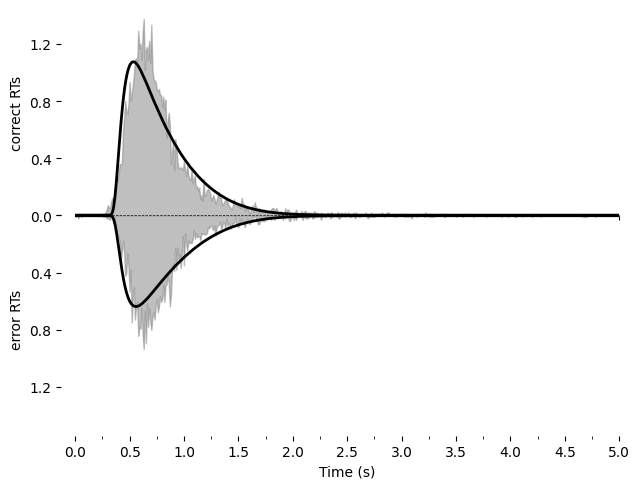

In [67]:
# Visualize fit diagnostics for Model 2 to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_2, sample=data_sample_filtered)
plt.show()